# Classification - FastText

This notebook discusses Multi-label classificaon methods for the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump in [FastText](https://radimrehurek.com/gensim_3.8.3/models/fasttext.html#module-gensim.models.fasttext) representation.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
from academia_tag_recommender.classifier import Classifier, available_classifier_paths

DATA_FOLDER = Path(MODELS_PATH) / 'classifier' / 'multi-label'
RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.data import documents
from academia_tag_recommender.test_train_data import get_y, get_test_train_data

def get_X():
    return np.vstack([document.text for document in documents])

X_train, X_test, y_train, y_test = get_test_train_data(get_X(), get_y(), scale=False)
print('Train set with shape ', X_train.shape)
print('Test set with shape', X_test.shape)

Train set with shape  (24812, 1)
Test set with shape (8270, 1)


<a id='data_preparation'/>

## Data Preparation

In [3]:
from academia_tag_recommender.embedded_data import word2vec, doc2vec, fasttext2vec

In [4]:
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition
preprocessing = PreprocessingDefinition('fasttext', 'basic', 'basic', 'english', '1,1', 'None')
paths = available_classifier_paths('fasttext')

def create_classifier(classifier, name, vector_size=100):
    path = [path for path in paths if name in path.name and 'fasttext' in path.name]
    if len(path) > 0:
        clf = load(path[0])
    else:
        clf = Classifier(classifier, preprocessing, name)
        X_train_, X_test_ = fasttext2vec(X_train, X_test, vector_size=vector_size, bigrams=True)
        clf.fit(X_train_, y_train)
        clf.score(X_test_, y_test)
        clf.save('fasttext')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

<a id='methods'/>

## Methods

* [Problem Transformation](#problem_transformation)
* [Algorithm Adaption](#algorithm_adaption)
* [Ensembles](#ensembles)

<a id='problem_transformation'/>

### Problem Transformation

- [DecisionTreeClassifier](#decisiontree)
- [KNeighborsClassifier](#kNN)
- [MLPClassifier](#mlp)
- [MultioutputClassifier](#multioutput)
- [Classwise Classifier](#classwise)
- [Classifier Chain](#chain)
- [Label Powerset](#label_powerset)

<a id='decisiontree'/>

**DecisionTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [5]:
from sklearn.tree import DecisionTreeClassifier

create_classifier(DecisionTreeClassifier(random_state=RANDOM_STATE), 'DecisionTreeClassifier')

Training: 71.52907967567444s
Test: 0.055212974548339844s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.022394195888754534     0.006892382103990327     0.18171503426037888      0.17916767432486902      0.16437765110074665      
micro                                                            0.17140221402214023      0.17745940783190067      0.17437822618488974      
macro                                                            0.07681859999910591      0.07774979559054156      0.07693497376830724      


<a id='kNN'/>

**KNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

create_classifier(KNeighborsClassifier(), 'KNeighborsClassifier')

Training: 0.9885983467102051s
Test: 90.21401453018188s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01311143639025011      0.06299879081015719      0.36445384925433294      0.21472188633615477      0.25225024471699203      
micro                                                            0.5207769854929923       0.2022922636103152       0.2913943729792942       
macro                                                            0.36200178744885564      0.08805822514829655      0.12594900799260716      


<a id='mlp'/>

**MLPClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [7]:
from sklearn.neural_network import MLPClassifier

create_classifier(MLPClassifier(random_state=RANDOM_STATE), 'MLPClassifier')

Training: 181.84474420547485s
Test: 0.14660143852233887s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01147712085534271      0.08778718258766627      0.48834340991535674      0.2880128980249899       0.3388376422717414       
micro                                                            0.6714252005663048       0.27177650429799427      0.3869322817514278       
macro                                                            0.5170424671554481       0.17644166170506725      0.23791637951051633      


<a id='multioutput'/>

**MultioutputClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier)

MultiouputClassifier transforms sklearn classifier into classifiers capable of Binary Relevence.

In [8]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

create_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'MultioutputClassifier(LinearSVC)')

Training: 36.86436986923218s
Test: 0.708122730255127s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011894609558963916     0.07629987908101572      0.35623740427247075      0.1935006045949214       0.23481631830483102      
micro                                                            0.7159309021113244       0.1781279847182426       0.28527724665391974      
macro                                                            0.3267414739786703       0.07841967933165879      0.11149055914749245      


In [9]:
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 31.176360607147217s
Test: 0.7101013660430908s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012199452682492205     0.0690447400241838       0.3078597339782346       0.16570939137444576      0.20198048022110895      
micro                                                            0.6907993966817496       0.1531041069723018       0.250654782846644        
macro                                                            0.2483076784783983       0.046646316170998924     0.06989519623690374      


<a id='chain'/>

**Classifier Chain** [source](http://scikit.ml/api/skmultilearn.problem_transform.cc.html#skmultilearn.problem_transform.ClassifierChain)

<cite>[Read et al., 2011][1]</cite>

[1]: https://doi.org/10.1007/s10994-011-5256-5

In [10]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import LinearSVC

create_classifier(ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)), 'ClassifierChain(LinearSVC)')

Training: 59.462576150894165s
Test: 2.3373069763183594s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011746324699293579     0.08198307134220073      0.4121825876662636       0.22691455058444174      0.2740162376921748       
micro                                                            0.6968447756461075       0.20988538681948424      0.32260432341175177      
macro                                                            0.36510527601996234      0.09588386364226349      0.13333327790711894      


In [11]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
create_classifier(ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'ClassifierChain(LogisticRegression)')

Training: 61.95880484580994s
Test: 2.3796801567077637s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012154267167313689     0.07194679564691657      0.34575977428456267      0.18833937928254738      0.22831653902996107      
micro                                                            0.6683729433272395       0.1745940783190067       0.27686482393032946      
macro                                                            0.26355760203141765      0.05203465331776003      0.07634375897775614      


<a id='label_powerset'/>

**Label Powerset** [source](http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset)

In [12]:
from skmultilearn.problem_transform import LabelPowerset

create_classifier(LabelPowerset(classifier=LinearSVC(random_state=RANDOM_STATE)), 'LabelPowerset(LinearSVC)')

Training: 1241.9160976409912s
Test: 1.5229370594024658s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013052249729523324     0.05900846432889964      0.5410600564288593       0.27433696090286175      0.3432833342930078       
micro                                                            0.5211585665193913       0.2534861509073543       0.3410763052208835       
macro                                                            0.3260258565107868       0.13025724121590113      0.16327180929888385      


In [13]:
# Does not finish
#create_classifier(LabelPowerset(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'LabelPowerset(LogisticRegression)')

<a id='Algorithm Adaption'/>

### Algorithm Adaption

- [MLkNN](#mlknn)
- [MLARAM](#mlaram)

<a id='mlknn'/>

**MLkNN** [source](http://scikit.ml/api/skmultilearn.adapt.mlknn.html#multilabel-k-nearest-neighbours)

> Firstly, for each test instance, its k nearest neighbors in the training set are identified. Then, according to statistical information gained from the label sets of these neighboring instances, i.e. the number of neighboring instances belonging to each possible class, maximum a posteriori (MAP) principle is utilized to determine the label set for the test instance.
<cite>[Zhang & Zhou, 2007][1]</cite>

[1]: https://doi.org/10.1016/j.patcog.2006.12.019

In [14]:
from skmultilearn.adapt import MLkNN

create_classifier(MLkNN(), 'MLkNN')

Training: 287.4469313621521s
Test: 77.6119818687439s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012730859797619806     0.06831922611850061      0.36907698508665865      0.21221483272873842      0.25176292201685185      
micro                                                            0.5639693821760525       0.1970391595033429       0.292044167610419        
macro                                                            0.354065074582009        0.11034666344815723      0.15294883350534125      


<a id='mlaram'/>

**MLARAM** [source](http://scikit.ml/api/skmultilearn.adapt.mlaram.html#skmultilearn.adapt.MLARAM)

> an extension of fuzzy Adaptive Resonance Associative Map (ARAM) – an Adaptive Resonance Theory (ART)based neural network. It aims at speeding up the classification process in the presence of very large data.
<cite>[F. Benites & E. Sapozhnikova, 2015][7]</cite>

[7]: https://doi.org/10.1109/ICDMW.2015.14

In [15]:
from skmultilearn.adapt import MLARAM

create_classifier(MLARAM(), 'MLARAM')

Training: 37.73678541183472s
Test: 233.6073920726776s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01670591230191561      0.042805320435308346     0.4351372906617767       0.31085247883917777      0.3243832594190053       
micro                                                            0.3493018503802929       0.2938872970391595       0.3192074277711499       
macro                                                            0.2149677732303754       0.1346804714128431       0.14642427053022875      


<a id='ensembles'/>

### Ensembles

- [RAkELo](#rakelo)
- [RAkELd](#rakeld)
- [MajorityVotingClassifier](#majority_voting)
- [LabelSpacePartitioningClassifier](#label_space)

<a id='rakelo'/>

**RAkELo** [source](http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO)

> Rakel: randomly breaking the initial set of labels into a number of small-sized labelsets, and employing [Label powerset] to train a corresponding multilabel classifier.
<cite>[Tsoumakas et al., 2011][1]</cite>


> Divides the label space in to m subsets of size k, trains a Label Powerset classifier for each subset and assign a label to an instance if more than half of all classifiers (majority) from clusters that contain the label assigned the label to the instance.
<cite>[skmultilearn][2]</cite>


[1]: https://doi.org/10.1109/TKDE.2010.164
[2]: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO

In [16]:
from skmultilearn.ensemble import RakelO
from sklearn.svm import LinearSVC

create_classifier(RakelO(
    base_classifier=LinearSVC(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LinearSVC)')

Training: 214.4679651260376s
Test: 118.7092227935791s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012065805384076879     0.07134220072551391      0.3207275292220879       0.16614873035066505      0.20599959693671907      
micro                                                            0.7210762331838565       0.15364769958434857      0.25331810484029776      
macro                                                            0.22013718396778778      0.04925591482223556      0.07044296235337173      


In [17]:
from sklearn.linear_model import LogisticRegression

create_classifier(RakelO(
    base_classifier=LogisticRegression(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LogisticRegression)')

Training: 315.007435798645s
Test: 126.89245176315308s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012025711194552282     0.07146311970979444      0.3451733172108021       0.18820838371624346      0.22804831001324352      
micro                                                            0.6901513735750328       0.176436863981654        0.2810288410318849       
macro                                                            0.3408073440413237       0.06239387141183692      0.09191193974649585      


<a id='rakeld'/>

**RAkELd** [source](http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD)

>Divides the label space in to equal partitions of size k, trains a Label Powerset classifier per partition and predicts by summing the result of all trained classifiers.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD

In [18]:
from skmultilearn.ensemble import RakelD

create_classifier(RakelD(base_classifier=LinearSVC(random_state=RANDOM_STATE)), 'RakelD(LinearSVC)')

Training: 67.5120050907135s
Test: 36.440678358078s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012053077069942086     0.07001209189842805      0.32488915759774284      0.16861144699717853      0.20894167098520178      
micro                                                            0.7170880557977333       0.15718312550762029      0.25784709432187786      
macro                                                            0.2507729594303562       0.05284608477445113      0.07600037383024534      


In [19]:
create_classifier(RakelD(base_classifier=LogisticRegression(random_state=RANDOM_STATE)), 'RakelD(LogisticRegression)')

Training: 95.44743609428406s
Test: 36.68747067451477s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012035257430153375     0.07158403869407497      0.3479201934703749       0.189993954050786        0.23002792652732193      
micro                                                            0.6853891336270191       0.17839568104725048      0.28310398422987987      
macro                                                            0.31293891472952484      0.06363100701206824      0.09333664193926215      


***Clustering***

In [20]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from academia_tag_recommender.test_train_data import get_all_labels

def get_graph_builder():
    graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
    label_names = get_all_labels()
    edge_map = graph_builder.transform(y_train)
    print("{} labels, {} edges".format(len(label_names), len(edge_map)))
    return graph_builder

In [21]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

def get_clusterer():
    graph_builder = get_graph_builder()
    clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
    partition = clusterer_igraph.fit_predict(X_train, y_train)
    return clusterer_igraph

In [22]:
clusterer_igraph = get_clusterer()

190 labels, 7717 edges


<a id='majority_vorting'/>

**MajorityVotingClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.voting.html#skmultilearn.ensemble.MajorityVotingClassifier)

In [23]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier
from skmultilearn.problem_transform import ClassifierChain

create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))')

Training: 50.38839387893677s
Test: 5.04201602935791s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012159994908674346     0.07037484885126966      0.32808544941555823      0.17912132204756145      0.2169783689372565       
micro                                                            0.675249807840123        0.1678849553294157       0.26891142146546776      
macro                                                            0.2635050485443275       0.050362988232068306     0.07445904338722138      


In [24]:
create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LinearSVC))')

Training: 59.02646470069885s
Test: 5.975003719329834s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011810602685674283     0.07702539298669892      0.38771866182990733      0.21210197501007658      0.25705677434214314      
micro                                                            0.7003884478973147       0.1981271797811858       0.30887829584388504      
macro                                                            0.35924589840986143      0.09088613186634359      0.12832103915272408      


<a id='label_space'/>

**LabelSpacePartitioningClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.partition.html#skmultilearn.ensemble.LabelSpacePartitioningClassifier)

<cite>[Szymański et al., 2016][2]</cite>

[2]: https://doi.org/10.3390/e18080282

In [25]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))')

Training: 50.76647973060608s
Test: 2.2122035026550293s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012159994908674346     0.07037484885126966      0.32808544941555823      0.17912132204756145      0.2169783689372565       
micro                                                            0.675249807840123        0.1678849553294157       0.26891142146546776      
macro                                                            0.2635050485443275       0.050362988232068306     0.07445904338722138      


In [26]:
create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))')

Training: 59.476898431777954s
Test: 2.190582036972046s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011810602685674283     0.07702539298669892      0.38771866182990733      0.21210197501007658      0.25705677434214314      
micro                                                            0.7003884478973147       0.1981271797811858       0.30887829584388504      
macro                                                            0.35924589840986143      0.09088613186634359      0.12832103915272408      


<a id='evaluation'/>

## Evaluation

In [27]:
paths = available_classifier_paths('fasttext')
evals = []
for path in paths:
    if '-' not in path.name:
        clf = load(path)
        evaluation = clf.evaluation
        evals.append([str(clf), evaluation])

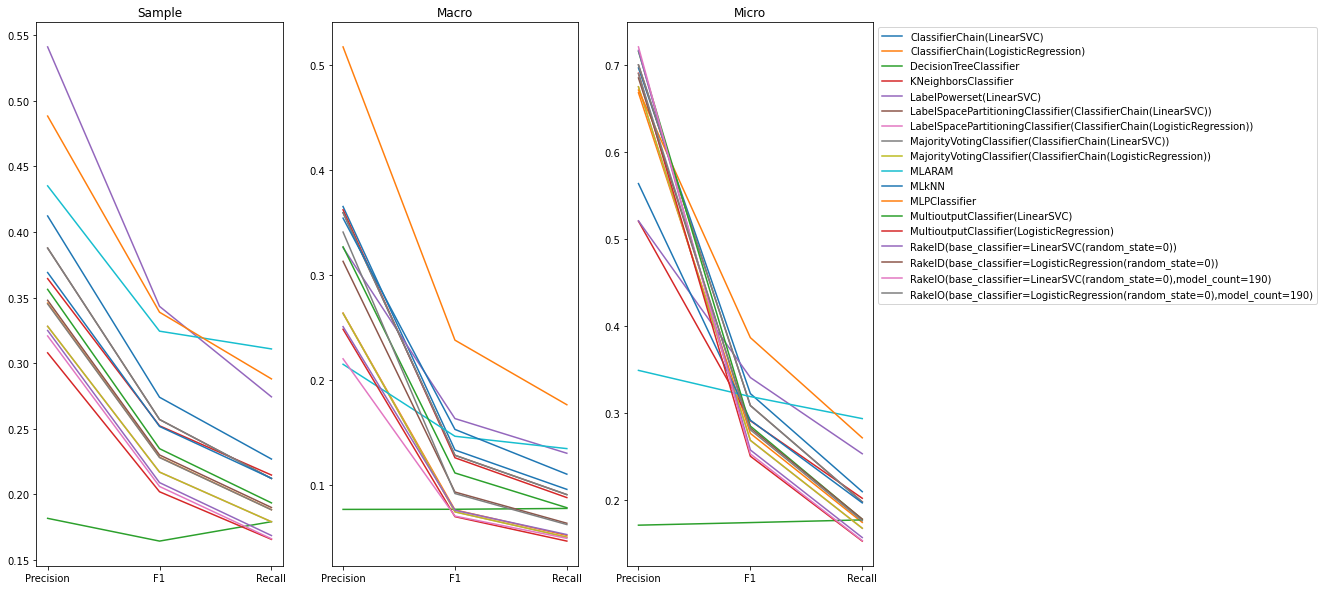

In [28]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [29]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [30]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray() 
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [31]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    if '-' not in clf_path.name:
        clf = load(clf_path)
        _, X_test_ = fasttext2vec(X_train, X_test)
        prediction = clf.predict(X_test_)
        label_accuracies = per_label_accuracy(y_test, prediction)
        report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
        classwise_report = {}
        for i, result in enumerate(report):
            if i < len(label_accuracies):
                classwise_report[result] = report[result]
                classwise_report[result]['accuracy'] = label_accuracies[int(result)]
        classwise_results.append((clf, classwise_report))

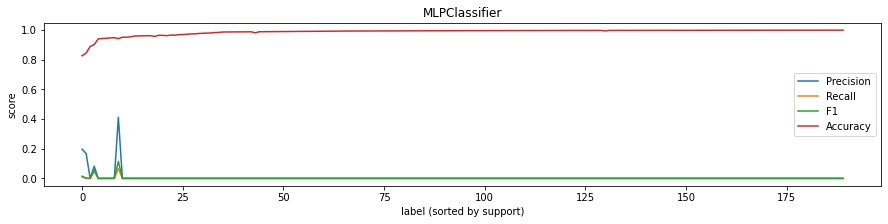

In [32]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()

**Impact of vector size**

In [34]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-param=100', 100)

Training: 37.55670380592346s
Test: 0.9005947113037109s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012165086234328264     0.06735187424425634      0.3136880290205562       0.1672652156388553       0.20468465096639218      
micro                                                            0.6945792026998524       0.1571087786259542       0.25625462044278435      
macro                                                            0.25088346413165485      0.04924600795705629      0.07316086601735936      


In [35]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-param=200', 200)

Training: 55.58745265007019s
Test: 1.4835212230682373s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011949341309743525     0.07110036275695285      0.3481600161225312       0.1853627569528416       0.22734122185754588      
micro                                                            0.7121212121212122       0.17490458015267177      0.2808334610081201       
macro                                                            0.2958840678349595       0.05708320634970544      0.08438477167208445      


In [36]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-param=500', 500)

Training: 106.70113754272461s
Test: 3.655280590057373s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01188379049194934      0.07085852478839177      0.3606569931479242       0.19165457476823858      0.23496084528128058      
micro                                                            0.7143392689784442       0.18182251908396946      0.28986499334474236      
macro                                                            0.3172364234401926       0.06028268857627493      0.08866954506074226      


In [37]:
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)-param=1000', 1000)

Training: 189.49680948257446s
Test: 7.489714860916138s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011876789919175205     0.07182587666263604      0.36100161225312377      0.19222692462716648      0.2355153451949099       
micro                                                            0.7150074850299402       0.18229961832061067      0.2905261557177615       
macro                                                            0.3145258067328026       0.060425603332849555     0.08880563867611492      


In [38]:
paths = available_classifier_paths('fasttext')
multi_names = ['MultioutputClassifier(LogisticRegression)-']
evals = []
for path in paths:
    if 'MultioutputClassifier(LogisticRegression)-' in str(path):
        clf = load(path)
        evaluation = clf.evaluation
        evals.append([int(str(clf.name_prefix).strip('MultioutputClassifier(LogisticRegression)-param=')), evaluation])

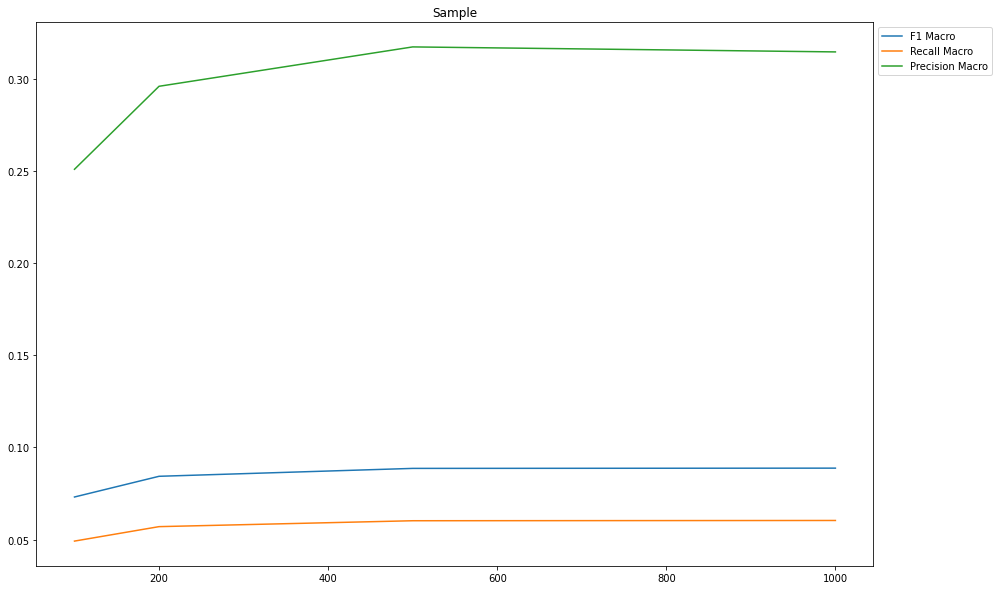

In [39]:
fig, axes = plt.subplots(figsize=(15,10))
axes.set_title('Sample')
evals = sorted(evals, key=lambda x: x[0])
x_ = [eval[0] for eval in evals]
axes.plot(x_, [eval[1].f1_macro for eval in evals], label='F1 Macro')
axes.plot(x_, [eval[1].recall_macro for eval in evals], label='Recall Macro')
axes.plot(x_, [eval[1].precision_macro for eval in evals], label='Precision Macro')
axes.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()